# Sentiment Analysis on Movie Reviews


### Individual Task 2. Yana Herman. Binary Logistic Regression

In [1]:
import os
import string
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

import nltk

import unicodedata, re
import warnings

### 1. Preparation & Data analysis

In [2]:
train = pd.read_csv('train.tsv', '\t')
test = pd.read_csv('test.tsv', '\t')

- train.tsv contains the phrases and their associated sentiment labels. SentenceId helps to track which phrases belong to a single sentence.
- test.tsv contains just phrases. You must assign a sentiment label to each phrase.

In [3]:
#dataset shapes
print("Train :",train.shape)
print("Test:",test.shape)

Train : (156060, 4)
Test: (66292, 3)


#### Checking for NULL or NA

In [4]:
train.columns[train.isna().any()].tolist()

[]

In [5]:
test.columns[test.isna().any()].tolist()

[]

#### Sentiment labels

In [6]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [7]:
train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


#### Number of phrases with sentiment labels

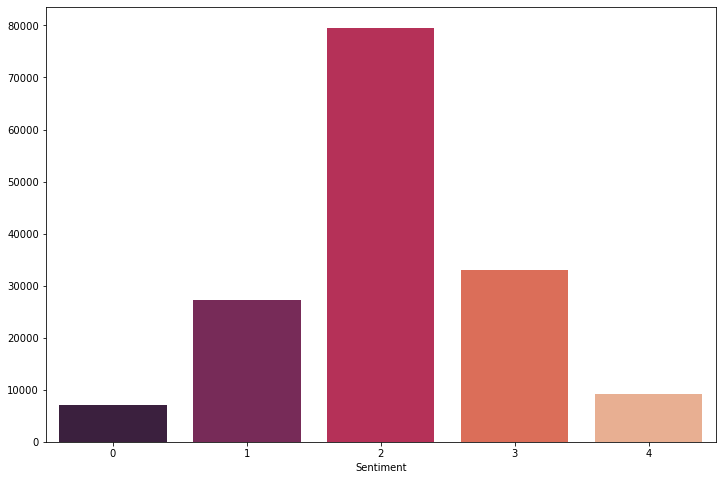

In [9]:
dist = train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot( dist.keys(), dist.values, palette="rocket");

We will use words to create a feature matrix

In [10]:
words = train['Phrase'].apply(nltk.word_tokenize)

#### Data normalization

In [11]:
# Remove non-ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# All words to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove punctuation
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove all numbers
def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    return words

In [12]:
words = words.apply(normalize) 
words.head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Phrase, dtype: object

Create a dictionary of unique words:

In [13]:
word_set = set()
for l in words:
    for e in l:
        word_set.add(e)
        
vocabulary = {word: ii for ii, word in enumerate(word_set, 1)}

print ("First 20 values: \n")

for x in list(vocabulary)[0:20]:
    print ("{}, {} ".format(x,  vocabulary[x]))


First 20 values: 

sam, 1 
devastated, 2 
everyjokehas, 3 
convenient, 4 
giveandtake, 5 
metropolitan, 6 
masculine, 7 
repulsive, 8 
misfiring, 9 
renegadecop, 10 
restored, 11 
wanted, 12 
selfcontrol, 13 
undisputed, 14 
between, 15 
blockbuster, 16 
definitive, 17 
enigma, 18 
coarse, 19 
morsels, 20 


We will need tokens to create the feature matrix. Phrases are encoded according to the dictionary.

In [14]:
tokens = words.apply(lambda l: [vocabulary[word] for word in l])
tokens.head()

0    [1330, 282, 10776, 5716, 9114, 2301, 11666, 10...
1    [1330, 282, 10776, 5716, 9114, 2301, 11666, 10...
2                                          [1330, 282]
3                                               [1330]
4                                                [282]
Name: Phrase, dtype: object

#### The feature matrix

In [15]:
# The longest phrase
max_len = tokens.str.len().max()
print(max_len)

# Make all token arrays equal by adding zeros in the end
all_tokens = np.array([t for t in tokens])
features = np.zeros((len(all_tokens), max_len), dtype=int)
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

from pprint import pprint
pprint(features)

48
array([[ 1330,   282, 10776, ...,     0,     0,     0],
       [ 1330,   282, 10776, ...,     0,     0,     0],
       [ 1330,   282,     0, ...,     0,     0,     0],
       ...,
       [ 6806, 13696,     0, ...,     0,     0,     0],
       [ 6806,     0,     0, ...,     0,     0,     0],
       [13696,     0,     0, ...,     0,     0,     0]])


#### Correlation between features

In this case correlation between features is not needed as the features do not influence each other.

#### Convertion to a binary classification problem.

- Let 0-1 be negative (0) 
- Let 2-4 be positive (1)

In [16]:
target = train["Sentiment"].apply(lambda i: 0 if i < 2 else 1)
target

0         0
1         1
2         1
3         1
4         1
         ..
156055    1
156056    0
156057    1
156058    1
156059    1
Name: Sentiment, Length: 156060, dtype: int64

### 2. Algorithm selection

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, shuffle = True, stratify = target)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((124848, 48), (124848,), (31212, 48), (31212,))

Hyperparameters:

In [18]:
alpha = 0.05
max_iters = 1000

#### Sklearn classifier

In [19]:
warnings.filterwarnings("ignore")

clf = LogisticRegression(solver='lbfgs', max_iter=max_iters, tol=1e-10)
clf = clf.fit(X_train, Y_train)


In [20]:
Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)

Results evaluation for training data:

In [21]:
# Accuracy
acc_scr = accuracy_score(Y_train, Y_train_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = confusion_matrix(Y_train, Y_train_pred)
print("Confusion Matrix:\nPredicted\t0\t1\nActual\n0\t\t{}\t{}\n1\t\t{}\t{}".format(conf_mtrx[0][0], conf_mtrx[0][1],conf_mtrx[1][0],conf_mtrx[1][1]))

# Precision
prec = precision_score(Y_train, Y_train_pred)
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = recall_score(Y_train, Y_train_pred)
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.77594

Confusion Matrix:
Predicted	0	1
Actual
0		811	26665
1		1308	96064

Precision: 0.78273

Recall: 0.98657


Results evaluation for test data:

In [22]:
# Accuracy
acc_scr = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = confusion_matrix(Y_test, Y_test_pred)
print("Confusion Matrix:\nPredicted\t0\t1\nActual\n0\t\t{}\t{}\n1\t\t{}\t{}".format(conf_mtrx[0][0], conf_mtrx[0][1],conf_mtrx[1][0],conf_mtrx[1][1]))

# Precision
prec = precision_score(Y_test, Y_test_pred)
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = recall_score(Y_test, Y_test_pred)
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.77550

Confusion Matrix:
Predicted	0	1
Actual
0		203	6666
1		341	24002

Precision: 0.78264

Recall: 0.98599


#### 2. Custom realization

In [23]:
def normalize(X):
    mean = np.mean(X)
    std = np.std(X)
    X_new = (X - mean) / std
    return X_new, mean, std

In [24]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.column_stack((ones, X))
    return X_new

In [25]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [26]:
def h(X, theta):
    z = np.dot(X, theta)
    return sigmoid(z)

In [27]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    
    J = (-y * np.log(h(X, theta)) - (1 - y) * np.log(1 - h(X, theta))).mean()
    
    return J

In [28]:
def derivative_theta(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None

    d_theta = np.dot(X.T, (h(X, theta) - y)) / m
    
    return d_theta

In [29]:
def gradient_descent(X, y, theta, alpha, epsilon, num_iters, print_J = True):
    m = X.shape[0]
    J_history = []
    
    J = cost_function(X, y, theta)
    
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        
        delta = derivative_theta(X, y, theta)
        theta = theta - alpha * delta
        
        J = cost_function(X, y, theta)
        
        J_history.append(J)
        
        if i % 1000 == 0 and print_J == True:
            print(J)
        
        if abs(J-J_history[-2]) < epsilon:
            break
            
    return theta, J_history

In [30]:
def predict(X, theta):
    X_test_proc = prepare_X(X)
    predictions = h(X_test_proc, theta)
    return predictions.round(0)

Hyperparameters:

In [31]:
alpha = 0.01
max_iters = 100000

In [32]:
X_new, mean, std = normalize(X_train)

In [33]:
X_new = prepare_X(X_new)
Y_new = Y_train.values.reshape((X_train.shape[0], 1))

In [34]:
#theta = np.zeros((X_new.shape[1], 1))
theta = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
theta.shape[0]

49

In [35]:
new_theta, Js = gradient_descent(X_new, Y_train, theta, alpha, 1e-7, max_iters, False)
print(new_theta, len(Js))

[ 0.79750459  0.01528796 -0.01607344 -0.03650645 -0.04604581 -0.05069408
 -0.05822043 -0.05159691 -0.05128454 -0.04414079 -0.03996187 -0.03371325
 -0.01448071 -0.02782152 -0.00625814 -0.01170241 -0.02754767 -0.00653086
  0.01056781  0.00787645 -0.02296424 -0.00182987 -0.01495654 -0.02720707
  0.02197153  0.01966137 -0.00697156 -0.0309146   0.01862933  0.02427491
  0.02805089  0.02238163  0.01113192 -0.02476146 -0.04357232 -0.04247165
 -0.05064778 -0.08448509 -0.09802828 -0.11567252 -0.15843851 -0.161316
 -0.19374451 -0.21389106 -0.22988661 -0.22991476 -0.2557413  -0.25210161
 -0.25549368] 8993


In [36]:
Y_train_pred = predict(X_train, new_theta)
print(Y_train_pred)

[0. 0. 0. ... 0. 0. 0.]


In [37]:
Y_test_pred = predict(X_test, new_theta)
print(Y_test_pred)

[0. 0. 0. ... 0. 1. 0.]


Results evaluation for training data:

In [38]:
# Accuracy
acc_scr = accuracy_score(Y_train, Y_train_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = pd.crosstab(Y_train, Y_train_pred, rownames=['Actual'], colnames=['Predicted'])
print("\tConfusion Matrix:\n{}".format(conf_mtrx))

# Precision
prec = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[1][0])
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[0][1])
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.37674

	Confusion Matrix:
Predicted    0.0    1.0
Actual                 
0          24182   3294
1          74519  22853

Precision: 0.87402

Recall: 0.23470


Results evaluation for test data:

In [39]:
# Accuracy
acc_scr = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: {:.5f}\n".format(acc_scr))

# Confusion Matrix:
conf_mtrx = pd.crosstab(Y_test, Y_test_pred, rownames=['Actual'], colnames=['Predicted'])
print("\tConfusion Matrix:\n{}".format(conf_mtrx))

# Precision
prec = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[1][0])
print("\nPrecision: {:.5f}".format(prec))

# Recall
recall = conf_mtrx[1][1]/(conf_mtrx[1][1] + conf_mtrx[0][1])
print("\nRecall: {:.5f}".format(recall))

Accuracy: 0.37364

	Confusion Matrix:
Predicted    0.0   1.0
Actual                
0           5989   880
1          18670  5673

Precision: 0.86571

Recall: 0.23304
